## Import the library

In [1]:
from transformers import DetrImageProcessor, DetrForObjectDetection, ViTModel, AutoModelForImageClassification, AutoImageProcessor
from torchvision import models, transforms
from PIL import Image, ImageDraw
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
# import matplotlib.patches as patches

/Users/a523461/anaconda3/envs/deeplearning/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/a523461/anaconda3/envs/deeplearning/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. 

## Create the sample dataset based on Animals10

In [2]:
import os
import random
import pandas as pd
from itertools import combinations

base_path = "animals10/raw-img"

categories = sorted(os.listdir(base_path))

images_per_class = 10
class_images = {}

for cat in categories:
    cat_path = os.path.join(base_path, cat)
    all_imgs = [f for f in os.listdir(cat_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    selected_imgs = random.sample(all_imgs, min(images_per_class, len(all_imgs)))
    class_images[cat] = [os.path.join(cat_path, img) for img in selected_imgs]

# positive pairs 
same_class_pairs = []
for cat, imgs in class_images.items():
    same_pairs = list(combinations(imgs, 2))
    same_class_pairs.extend([(a, b, cat, cat, 1) for a, b in same_pairs[:5]])

# negative pairs
diff_class_pairs = []
for i in range(len(categories)):
    for j in range(i+1, len(categories)):
        for _ in range(3):  
            img1 = random.choice(class_images[categories[i]])
            img2 = random.choice(class_images[categories[j]])
            diff_class_pairs.append((img1, img2, categories[i], categories[j], 0))

# save document
all_pairs = same_class_pairs + diff_class_pairs
random.shuffle(all_pairs)
df = pd.DataFrame(all_pairs, columns=["image1", "image2", "class1", "class2", "same_species"])
df.to_csv("animal_pairs.csv", index=False)

print("✅ Image pairs were successfully generated, with {} pairs in total, saved as animal_pairs.csv".format(len(df)))

✅ Image pairs were successfully generated, with 185 pairs in total, saved as animal_pairs.csv


# Part 1
### Detect how many animals are in the image and draw the bounding boxes

In [3]:
import os
dataset_path = "animals10/raw-img"
classes = sorted(os.listdir(dataset_path))
print("All categories", classes)

All categories ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


### Run DETR model

In [4]:
detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# Detection boxes
def draw_detr_boxes(image, threshold=0.8):
    inputs = detr_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = detr_model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = detr_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]

    draw = ImageDraw.Draw(image)
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        draw.rectangle(box, outline="red", width=3)
        name = detr_model.config.id2label[label.item()]
        draw.text((box[0], box[1]), f"{name} {score:.2f}", fill="red")
    return image

### Test 

(-0.5, 799.5, 599.5, -0.5)

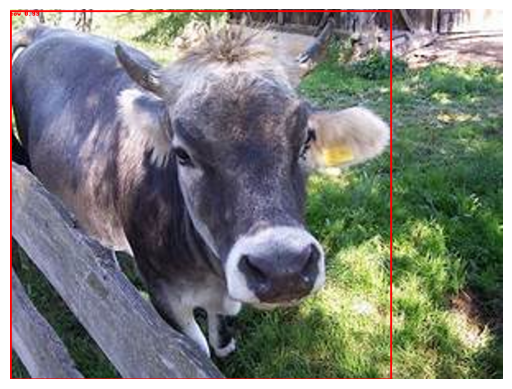

In [6]:
test_image_path = "animals10/raw-img/mucca/OIP-_-tg9T0bzHlxyBhXL8Z46AHaFj.jpeg"
image = Image.open(test_image_path).convert("RGB")
image = image.resize((800, 600))
image = draw_detr_boxes(image, threshold=0.8)
plt.imshow(image)
plt.axis('off') 

# Part 2
### For each detected animal, classify its species.

### Run ViT Model

In [7]:
vit_classification_model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
vit_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [8]:
# Run the image through ViT for feature extraction
def classify_animal(image):
    inputs = vit_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = vit_classification_model(**inputs)
    logits = outputs.logits
    pred_id = logits.argmax(-1).item()
    return vit_classification_model.config.id2label[pred_id]

### Test

Predicted label: ox


(-0.5, 299.5, 224.5, -0.5)

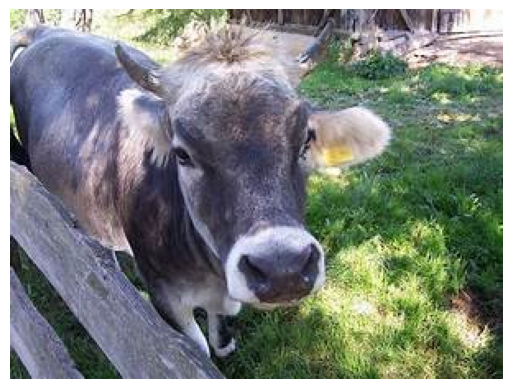

In [9]:
image = Image.open("animals10/raw-img/mucca/OIP-_-tg9T0bzHlxyBhXL8Z46AHaFj.jpeg").convert("RGB")
label = classify_animal(image)
print("Predicted label:", label)
plt.imshow(image)
plt.axis('off') 

# Models 

### ViT Model

In [10]:
vit_classification_model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
vit_feature_model = ViTModel.from_pretrained("google/vit-base-patch16-224")
vit_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

### ViT feature extraction
def get_vit_embedding(image): 
    inputs = vit_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = vit_feature_model(**inputs)
    return outputs.last_hidden_state[:, 0, :]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


### ResNet Model

In [11]:
resnet_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet_model.eval()

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
### ResNet feature extraction
def get_resnet_embedding(image):
    tensor = resnet_transform(image).unsqueeze(0)
    with torch.no_grad():
        features = resnet_model(tensor)
    return features



### MobileNet with Fine-tuning 

In [12]:
import torch
from torchvision import transforms
from PIL import Image
from torchvision.models import mobilenet_v2
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transformation for MobileNet
mobilenet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# initialize MobileNetV2 model
mobilenet_embedder = mobilenet_v2(pretrained=False)
mobilenet_embedder.classifier[1] = nn.Identity() 
mobilenet_embedder.load_state_dict(
    torch.load("mobilenetv2_animals10_finetuned.pth", map_location=device),
    strict=False
)
mobilenet_embedder.eval().to(device)

# MobileNet feature extraction
def get_mobilenet_embedding(image: Image.Image):
    img_tensor = mobilenet_transform(image).unsqueeze(0).to(device) 
    with torch.no_grad():
        embedding = mobilenet_embedder(img_tensor)
    return embedding.squeeze(0).cpu().numpy() 

/Users/a523461/anaconda3/envs/deeplearning/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/a523461/anaconda3/envs/deeplearning/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### CLIP

In [13]:
from transformers import CLIPProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/Users/a523461/anaconda3/envs/deeplearning/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [14]:
def get_clip_similarity(image1, image2, clip_model, clip_processor):
    inputs = clip_processor(images=[image1, image2], return_tensors="pt")
    device = clip_model.device

    for k in inputs:
        inputs[k] = inputs[k].to(device)

    with torch.no_grad():
        embeddings = clip_model.get_image_features(**inputs)
        embeddings = embeddings / embeddings.norm(dim=-1, keepdim=True)

    sim_clip = torch.nn.functional.cosine_similarity(
        embeddings[0].unsqueeze(0), embeddings[1].unsqueeze(0), dim=1
    ).item()
    return sim_clip

In [15]:
### Cosine similarity
def cosine_sim1(tensor1, tensor2): 
    return F.cosine_similarity(tensor1, tensor2).item()
from sklearn.metrics.pairwise import cosine_similarity

def cosine_sim2(a, b):
    return cosine_similarity([a], [b])[0][0]

### Evaluation Metrics

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model_by_threshold(sim_column, df, threshold=0.75):
    preds = df[sim_column].apply(lambda x: 1 if x > threshold else 0)
    gt = df["ground_truth"]

    acc = accuracy_score(gt, preds)
    prec = precision_score(gt, preds)
    rec = recall_score(gt, preds)
    f1 = f1_score(gt, preds)

    print(f"Model: {sim_column}")
    print(f"Accuracy:  {acc:.2%}")
    print(f"Precision: {prec:.2%}")
    print(f"Recall:    {rec:.2%}")
    print(f"F1 Score:  {f1:.2%}")
    print("-" * 35)

## Part 3
### Comparation with two different images to determine if they are same species


In [17]:
### Explain the final score
def explain(score): 
    if score >= 0.9:
        return "🟢 Same species (high confidence)"
    elif score >= 0.8:
        return "🟡 High possibly same species"
    elif score >= 0.7:
        return "🟡 Possibly in same family but not same species"
    else:
        return "🔴 Different species"

In [18]:
def compute_similarity_scores(img_path1, img_path2):
    image1 = Image.open(img_path1).convert("RGB")
    image2 = Image.open(img_path2).convert("RGB")

    label1 = classify_animal(image1)
    label2 = classify_animal(image2)

    emb_vit1 = get_vit_embedding(image1)
    emb_vit2 = get_vit_embedding(image2)
    sim_vit = cosine_sim1(emb_vit1, emb_vit2)

    emb_resnet1 = get_resnet_embedding(image1)
    emb_resnet2 = get_resnet_embedding(image2)
    sim_resnet = cosine_sim1(emb_resnet1, emb_resnet2)

    emb_mobile1 = get_mobilenet_embedding(image1)
    emb_mobile2 = get_mobilenet_embedding(image2)
    sim_mobile = cosine_sim2(emb_mobile1, emb_mobile2)

    sim_clip = get_clip_similarity(image1, image2, clip_model, clip_processor)

    label_match = 1.0 if label1 == label2 else 0.0

    return {
        "label1": label1,
        "label2": label2,
        "vit_score": sim_vit,
        "resnet_score": sim_resnet,
        "mobilenet_score": sim_mobile,
        "clip_score": sim_clip,
        "label_match": label_match
    }

## Model Evaluation

In [19]:
from tqdm import tqdm
results = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    scores = compute_similarity_scores(row['image1'], row['image2'])
    scores.update({
        "img1": row["image1"],
        "img2": row["image2"],
        "ground_truth": row["same_species"]
    })
    results.append(scores)

df_results = pd.DataFrame(results)
df_results.to_csv("animal_pairs_scores_raw.csv", index=False)


100%|██████████| 185/185 [06:08<00:00,  1.99s/it]


In [20]:
df_results = pd.read_csv("animal_pairs_results.csv")
print(df_results.columns)

Index(['label1', 'label2', 'vit_score', 'resnet_score', 'mobilenet_score',
       'clip_score', 'label_match', 'final_score', 'decision', 'img1', 'img2',
       'ground_truth'],
      dtype='object')


In [21]:
evaluate_model_by_threshold("vit_score", df_results)
evaluate_model_by_threshold("resnet_score", df_results)
evaluate_model_by_threshold("clip_score", df_results)
evaluate_model_by_threshold("mobilenet_score", df_results)
evaluate_model_by_threshold("label_match", df_results, threshold=0.5)

Model: vit_score
Accuracy:  74.59%
Precision: 100.00%
Recall:    6.00%
F1 Score:  11.32%
-----------------------------------
Model: resnet_score
Accuracy:  74.05%
Precision: 100.00%
Recall:    4.00%
F1 Score:  7.69%
-----------------------------------
Model: clip_score
Accuracy:  88.11%
Precision: 93.75%
Recall:    60.00%
F1 Score:  73.17%
-----------------------------------
Model: mobilenet_score
Accuracy:  96.76%
Precision: 95.83%
Recall:    92.00%
F1 Score:  93.88%
-----------------------------------
Model: label_match
Accuracy:  88.65%
Precision: 100.00%
Recall:    58.00%
F1 Score:  73.42%
-----------------------------------


# Grid Search for the weight

In [22]:
from sklearn.metrics import f1_score

candidate_weights = [
    (0.6, 0.3, 0.1),
    (0.5, 0.3, 0.2),
    (0.4, 0.4, 0.2),
    (0.4, 0.5, 0.1),
    (0.3, 0.6, 0.1),
    (0.6, 0.2, 0.2)
]

best_f1 = 0
best_config = None

for weights in candidate_weights:
    w_m, w_c, w_l = weights
    for threshold in [0.85, 0.8, 0.75, 0.7]:
        preds = []

        for _, row in df_results.iterrows():
            score = (
                w_m * row["mobilenet_score"] +
                w_c * row["clip_score"] +
                w_l * row["label_match"]
            )
            pred = 1 if score >= threshold else 0
            preds.append(pred)

        f1 = f1_score(df_results["ground_truth"], preds)
        print(f"Weights: {weights}, Threshold: {threshold}, F1: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_config = (weights, threshold)

print("✅ Best Config:", best_config, "| F1 Score:", best_f1)

Weights: (0.6, 0.3, 0.1), Threshold: 0.85, F1: 0.5507
Weights: (0.6, 0.3, 0.1), Threshold: 0.8, F1: 0.7179
Weights: (0.6, 0.3, 0.1), Threshold: 0.75, F1: 0.8372
Weights: (0.6, 0.3, 0.1), Threshold: 0.7, F1: 0.9474
Weights: (0.5, 0.3, 0.2), Threshold: 0.85, F1: 0.5915
Weights: (0.5, 0.3, 0.2), Threshold: 0.8, F1: 0.6842
Weights: (0.5, 0.3, 0.2), Threshold: 0.75, F1: 0.7500
Weights: (0.5, 0.3, 0.2), Threshold: 0.7, F1: 0.7654
Weights: (0.4, 0.4, 0.2), Threshold: 0.85, F1: 0.5294
Weights: (0.4, 0.4, 0.2), Threshold: 0.8, F1: 0.7013
Weights: (0.4, 0.4, 0.2), Threshold: 0.75, F1: 0.7342
Weights: (0.4, 0.4, 0.2), Threshold: 0.7, F1: 0.7654
Weights: (0.4, 0.5, 0.1), Threshold: 0.85, F1: 0.4375
Weights: (0.4, 0.5, 0.1), Threshold: 0.8, F1: 0.6301
Weights: (0.4, 0.5, 0.1), Threshold: 0.75, F1: 0.8095
Weights: (0.4, 0.5, 0.1), Threshold: 0.7, F1: 0.8889
Weights: (0.3, 0.6, 0.1), Threshold: 0.85, F1: 0.3871
Weights: (0.3, 0.6, 0.1), Threshold: 0.8, F1: 0.6111
Weights: (0.3, 0.6, 0.1), Threshold: 

In [23]:
def apply_fusion(df, mobilenet_weight=0.6, clip_weight=0.3, label_weight=0.1, threshold=0.7):
    scores = []
    for _, row in df.iterrows():
        score = (
            mobilenet_weight * row["mobilenet_score"] +
            clip_weight * row["clip_score"] +
            label_weight * row["label_match"]
        )
        decision = explain(score)
        scores.append((score, decision))

    df["final_score"] = [s[0] for s in scores]
    df["decision"] = [s[1] for s in scores]
    return df

In [24]:
df_fused = apply_fusion(df_results, mobilenet_weight=0.6, clip_weight=0.3, label_weight=0.1)
df_fused.to_csv("animal_pairs_with_fusion.csv", index=False)

## Visualize the results

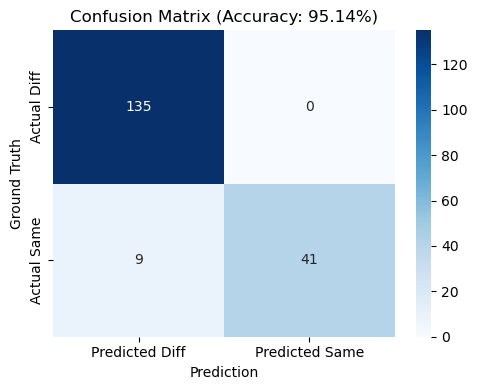

In [25]:
# Visualize the results
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

df_results = pd.read_csv("animal_pairs_with_fusion.csv")

df_results = pd.DataFrame({
    "decision": df_results["decision"],
    "ground_truth": df_results["ground_truth"]
})

df_results["predicted"] = df_results["decision"].apply(lambda x: 1 if "same" in x else 0)

accuracy = accuracy_score(df_results["ground_truth"], df_results["predicted"])
cm = confusion_matrix(df_results["ground_truth"], df_results["predicted"])

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Diff", "Predicted Same"],
            yticklabels=["Actual Diff", "Actual Same"])
plt.title(f"Confusion Matrix (Accuracy: {accuracy:.2%})")
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.tight_layout()
plt.show()

/var/folders/mb/k7ytllq12898_g9h09d9x9r80000gp/T/ipykernel_85617/2465329090.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Blues_d")


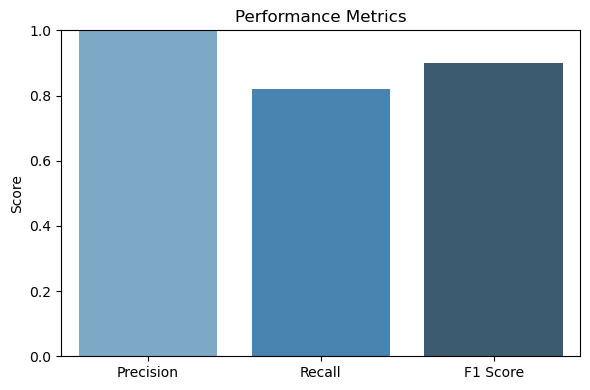

Precision: 100.00%
Recall: 82.00%
F1 Score: 90.11%


In [26]:
precision = precision_score(df_results["ground_truth"], df_results["predicted"])
recall = recall_score(df_results["ground_truth"], df_results["predicted"])
f1 = f1_score(df_results["ground_truth"], df_results["predicted"])

metrics = {
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

plt.figure(figsize=(6, 4))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Blues_d")
plt.ylim(0, 1)
plt.title("Performance Metrics")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

for name, val in metrics.items():
    print(f"{name}: {val:.2%}")

## Compare all pairs

In [27]:
def show_image(image1, image2):
    results = {}
    results = compute_similarity_scores(image1, image2)
    final_score = (
        0.6 * results["mobilenet_score"] +
        0.3 * results["clip_score"] +
        0.1 * results["label_match"]
    )
    decision = explain(final_score)
    print("Results:", results)

    
    image1 = Image.open(image1).convert("RGB")
    image2 = Image.open(image2).convert("RGB")
    
    image1_boxed = draw_detr_boxes(image1.copy())
    image2_boxed = draw_detr_boxes(image2.copy())

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image1_boxed)
    plt.axis("off")
    plt.title(f"Image 1: {results['label1']}")

    plt.subplot(1, 2, 2)
    plt.imshow(image2_boxed)
    plt.axis("off")
    plt.title(f"Image 2: {results['label2']}")

    plt.suptitle(
        f"MobilesNet: {results['mobilenet_score']:.3f} | CLIP: {results['clip_score']:.3f} | LabelMatch: {results['label_match']:.1f}\nFinal: {final_score:.3f} → {decision}",
        fontsize=12
    )
    plt.tight_layout()
    plt.show()


# Comparison Test and results

Results: {'label1': 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis', 'label2': 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis', 'vit_score': 0.7298460602760315, 'resnet_score': 0.7316427826881409, 'mobilenet_score': 0.7482551, 'clip_score': 0.8045853972434998, 'label_match': 1.0}


/var/folders/mb/k7ytllq12898_g9h09d9x9r80000gp/T/ipykernel_85617/2338290397.py:34: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from current font.
  plt.tight_layout()
/Users/a523461/anaconda3/envs/deeplearning/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


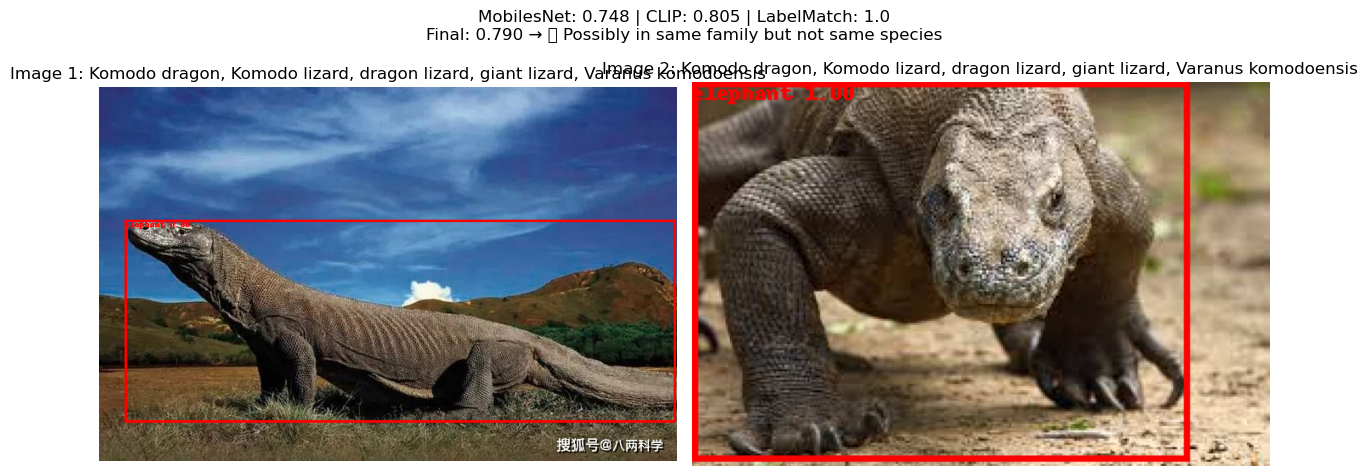

In [28]:
show_image("im2.jpeg", "images.jpeg")

Results: {'label1': 'goose', 'label2': 'drake', 'vit_score': 0.3229716122150421, 'resnet_score': 0.4283548891544342, 'mobilenet_score': 0.8149606, 'clip_score': 0.8402310013771057, 'label_match': 0.0}


/var/folders/mb/k7ytllq12898_g9h09d9x9r80000gp/T/ipykernel_85617/2338290397.py:34: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from current font.
  plt.tight_layout()
/Users/a523461/anaconda3/envs/deeplearning/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


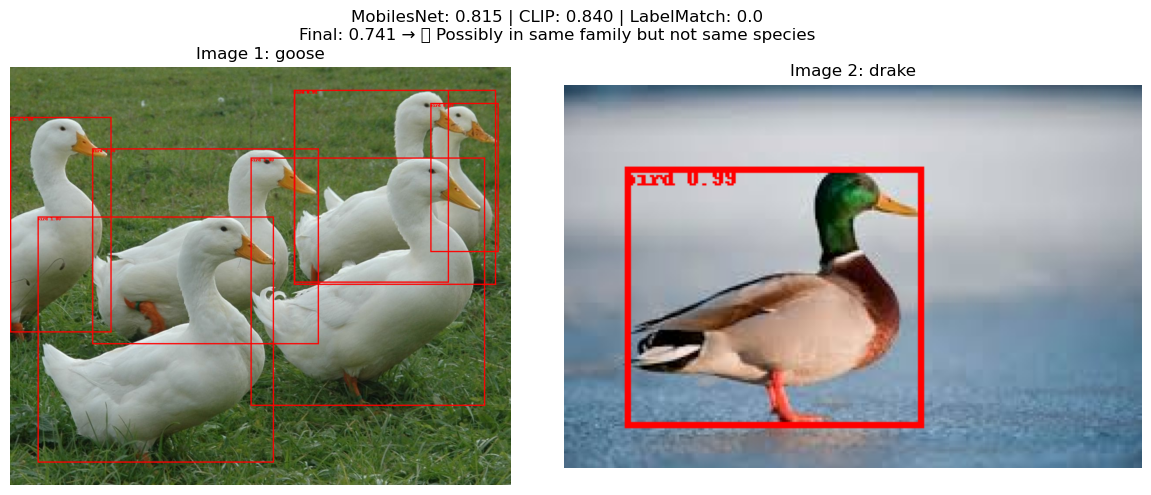

In [29]:
image1 = "Amerikanische_Pekingenten_2013_01c.jpg"
image2 = "duck.jpeg"
show_image(image1, image2)

Results: {'label1': 'ram, tup', 'label2': 'ram, tup', 'vit_score': 0.7660330533981323, 'resnet_score': 0.7368034720420837, 'mobilenet_score': 0.87682664, 'clip_score': 0.824082612991333, 'label_match': 1.0}


/var/folders/mb/k7ytllq12898_g9h09d9x9r80000gp/T/ipykernel_85617/2338290397.py:34: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from current font.
  plt.tight_layout()
/Users/a523461/anaconda3/envs/deeplearning/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


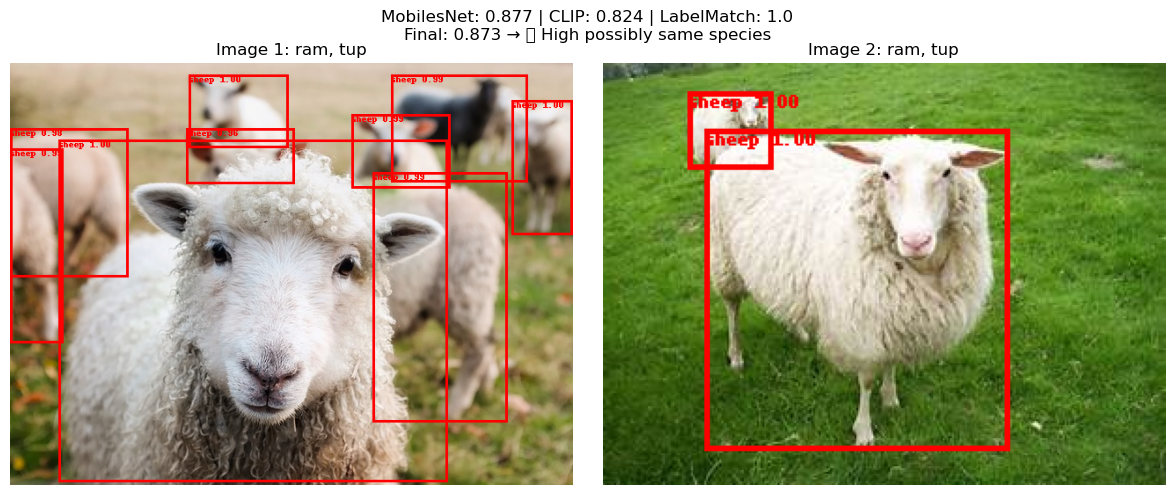

In [30]:
# animals10/raw-img/pecora/e83cb90a28fc093ed1584d05fb1d4e9fe777ead218ac104497f5c978a6e8b0b1_640.jpg
# animals10/raw-img/pecora/OIP-z8re0zV1hU2DxjsvTdqYIgHaFj.jpeg
show_image(
    "animals10/raw-img/pecora/e83cb90a28fc093ed1584d05fb1d4e9fe777ead218ac104497f5c978a6e8b0b1_640.jpg",
    "animals10/raw-img/pecora/OIP-z8re0zV1hU2DxjsvTdqYIgHaFj.jpeg"
)

Results: {'label1': 'fox squirrel, eastern fox squirrel, Sciurus niger', 'label2': 'fox squirrel, eastern fox squirrel, Sciurus niger', 'vit_score': 0.9088290929794312, 'resnet_score': 0.772101104259491, 'mobilenet_score': 0.94125926, 'clip_score': 0.9504989385604858, 'label_match': 1.0}


/var/folders/mb/k7ytllq12898_g9h09d9x9r80000gp/T/ipykernel_85617/2338290397.py:34: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
  plt.tight_layout()
/Users/a523461/anaconda3/envs/deeplearning/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


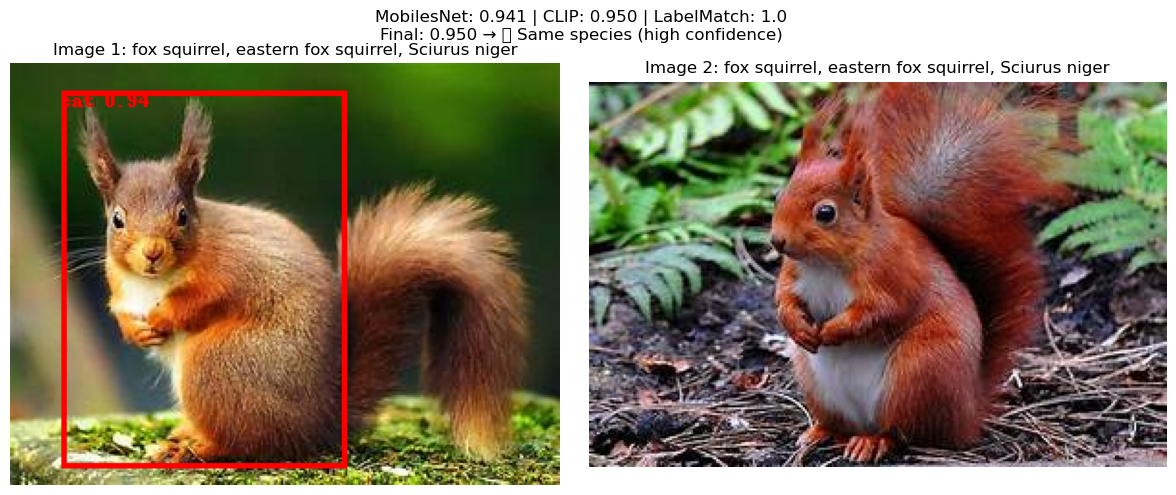

In [31]:
# animals10/raw-img/scoiattolo/OIP-_1fZ4ZAaldRi0hgUW7DVuQHaFr.jpeg
# animals10/raw-img/scoiattolo/OIP-xXppqCqAAttfrEER-aFOOAHaE7.jpeg
show_image(
    "animals10/raw-img/scoiattolo/OIP-_1fZ4ZAaldRi0hgUW7DVuQHaFr.jpeg",
    "animals10/raw-img/scoiattolo/OIP-xXppqCqAAttfrEER-aFOOAHaE7.jpeg"
)

Results: {'label1': 'African elephant, Loxodonta africana', 'label2': 'African elephant, Loxodonta africana', 'vit_score': 0.6487336158752441, 'resnet_score': 0.7017608880996704, 'mobilenet_score': 0.92340934, 'clip_score': 0.810998797416687, 'label_match': 1.0}


/var/folders/mb/k7ytllq12898_g9h09d9x9r80000gp/T/ipykernel_85617/2338290397.py:34: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from current font.
  plt.tight_layout()
/Users/a523461/anaconda3/envs/deeplearning/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


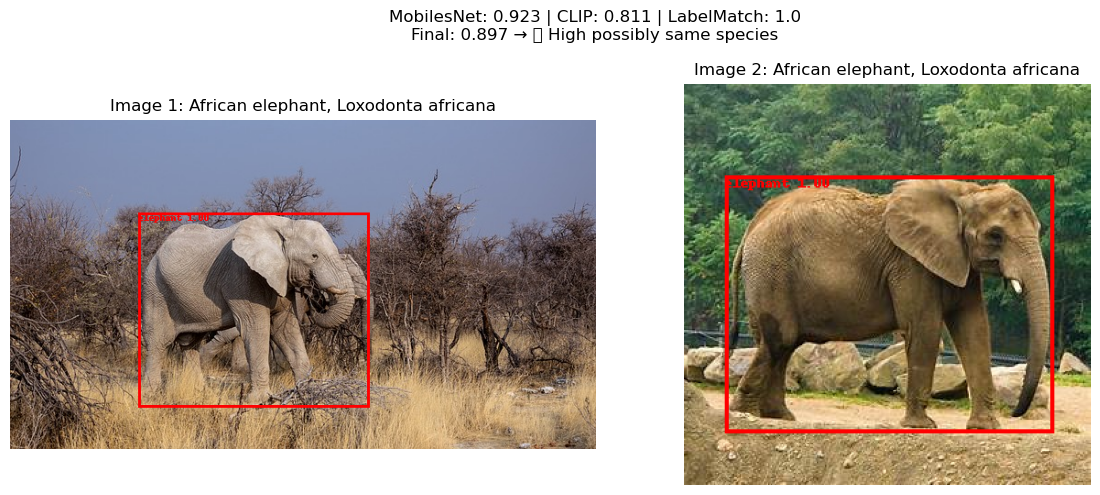

In [32]:
# animals10/raw-img/elefante/e83cb10620f2073ed1584d05fb1d4e9fe777ead218ac104497f5c978a4eebdbd_640.jpg
# animals10/raw-img/elefante/OIP-X-a3t3aeF084JmlQz1D5tgHaHT.jpeg
show_image(
    "animals10/raw-img/elefante/e83cb10620f2073ed1584d05fb1d4e9fe777ead218ac104497f5c978a4eebdbd_640.jpg",
    "animals10/raw-img/elefante/OIP-X-a3t3aeF084JmlQz1D5tgHaHT.jpeg"
)

Results: {'label1': 'sorrel', 'label2': 'sorrel', 'vit_score': 0.629586935043335, 'resnet_score': 0.7714123725891113, 'mobilenet_score': 0.91388345, 'clip_score': 0.8475514054298401, 'label_match': 1.0}


/var/folders/mb/k7ytllq12898_g9h09d9x9r80000gp/T/ipykernel_85617/2338290397.py:34: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
  plt.tight_layout()
/Users/a523461/anaconda3/envs/deeplearning/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


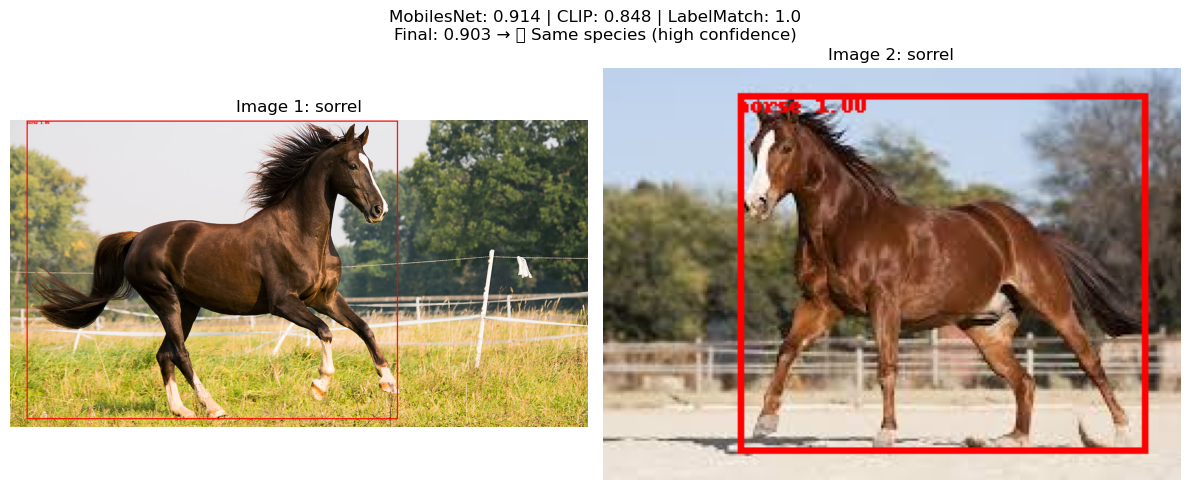

In [33]:
# horse.jpg
# horse2.jpg
show_image(
    "horse.jpg",
    "horse2.jpeg"
)

Results: {'label1': 'leopard, Panthera pardus', 'label2': 'jaguar, panther, Panthera onca, Felis onca', 'vit_score': 0.7155256271362305, 'resnet_score': 0.8726273775100708, 'mobilenet_score': 0.82923234, 'clip_score': 0.8932704925537109, 'label_match': 0.0}


/var/folders/mb/k7ytllq12898_g9h09d9x9r80000gp/T/ipykernel_85617/2338290397.py:34: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from current font.
  plt.tight_layout()
/Users/a523461/anaconda3/envs/deeplearning/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


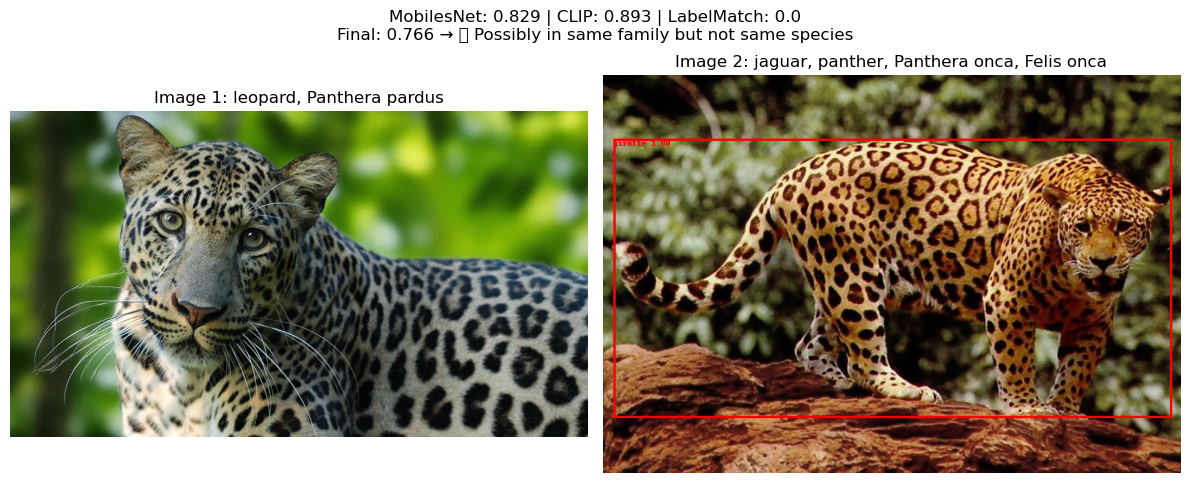

In [34]:

show_image(
    "leopard.jpg",
    "jaguar.jpg"
)